<h1>Learning Performance</h1>

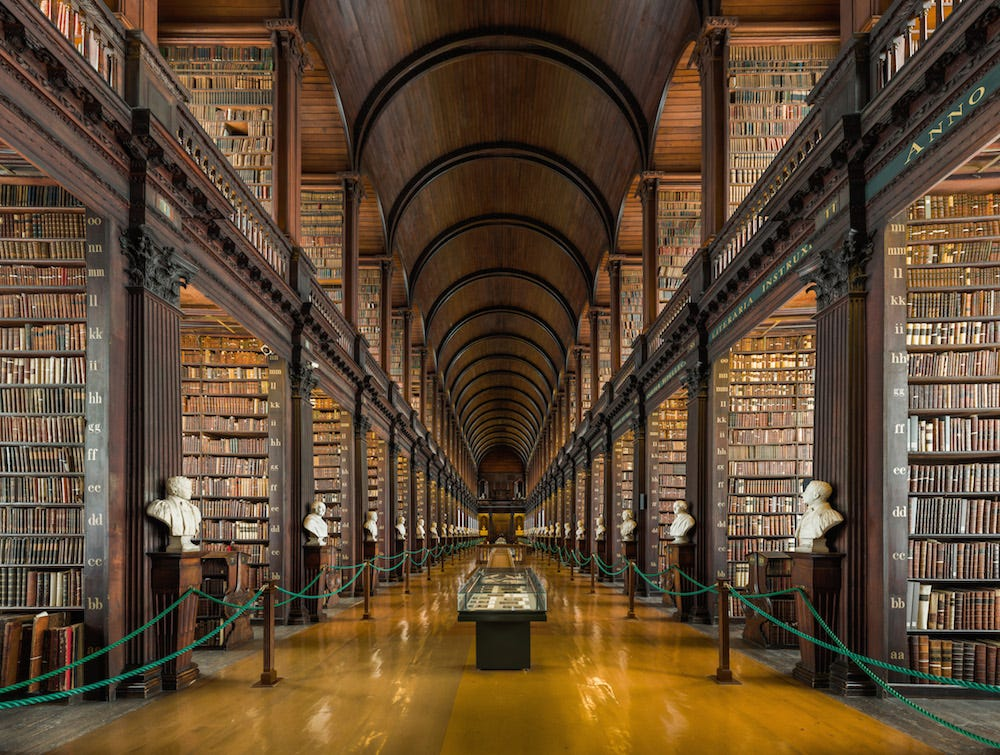

In [1]:
#%matplotlib inline
import requests
import IPython.display as Disp
url = 'https://i.insider.com/5720d775dd0895167d8b468b?width=1000&format=jpeg&auto=webp'
Disp.Image(requests.get(url).content, width=800)

<h2>Table of Contents</h2> 

* [I. About the Project](#chapter1)<br>
* [II. Importing Libraries](#chapter2)<br>
* [III. Exploratory Data Analysis](#chapter3)<br>
* [IV. Building the Models](#chapter4)<br>
    * [1. Simple Linear Regression](#sec4_1)<br>
    * [2. Multiple Linear Regression - 2 variables](#sec4_2)<br>
    * [3. Multiple Linear Regression - 3 variable](#sec4_3)<br>
    * [4. Lasso Regression](#sec4_4)<br>
    * [5. Ridge Regression](#sec4_5)<br>
    * [6. Decision Tree Regression](#sec4_6)<br>
    * [7. Polynomial Regression](#sec4_7)<br>
    * [Model summary](#sec4_8)<br>
* [V. Final Report](#chapter5)<br>


<a class="anchor"  id="chapter1"></a>
# I. About the Project 

<p>Learning process accompanies us all the lives. The goal of this project is to answer the question - which are the key factors of learning performance? Is it sleep duration or maybe the number of hours spent learning? To do so, I will analyze the Student Performance Dataset from Kaggle. At the beginning, I will perform Exploratory Data Analysis to see the structure and gain deeper understanding of the data. Next, I will suggest several models and will perform cross-validation to choose the best one. At the end, I will present the metrics of chosen models.</p>

<a class="anchor"  id="chapter2"></a>
# II. Importing Libraries  

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, max_error, mean_absolute_error


<a class="anchor"  id="chapter3"></a>
# III. Exploratory Data Analysis  

In [3]:
df = pd.read_csv('/kaggle/input/student-performance-multiple-linear-regression/Student_Performance.csv')
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [4]:
df.shape

(10000, 6)

In [5]:
df = df.replace({'Extracurricular Activities': {'Yes': 1, 'No': 0}})
df['Extracurricular Activities'] = df['Extracurricular Activities'].astype(int)
df.head(3)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0


This dataset contains 10000 rows and 6 columns. Description of the columns is based on kaggle.com.

<b>Hours Studied</b> - it's total hours spent on studying <br>
<b>Previous Scores</b> - the scores obtained by a student in previous tests <br>
<b>Extracurricular Activities</b> - whether the student participates in extracurricular activities or not<br>
<b>Sleep Hours</b> - average number of sleeping hours per day<br>
<b>Sample Question Papers Practiced</b> - the number of sample question papers the student practiced<br>

<b>Performance Index</b> - A measure of the overall performance of each student. The performance index represents the student's academic performance and has been rounded to the nearest integer. The index ranges from 10 to 100, with higher values indicating better performance. <br>
 

The first five features are treated as independent variables (explanatory variables) and the Performance Index as a target. Every feature is quantitative, apart from Extracurricular Activities which was expressed in categorical manner - Yes or No. We changed this into 1's and 0's.

Let's check if the data has missing values and duplicates.



In [6]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

In [7]:
df.duplicated().sum()

127

There are no missing values in the dataset, but there are 127 duplicates.
The question here is: should we really drop duplicates? To wisely answer this question, let's take a look at the the basic statistics of each feature in the dataset.

In [8]:
df.describe()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,0.494800,6.530600,4.583300,55.224800
std,2.589309,17.343152,0.499998,1.695863,2.867348,19.212558
min,1.000000,40.000000,0.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,0.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,0.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,1.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,1.000000,9.000000,9.000000,100.000000


The variables have very limited range. Sleep Hours varies from 4 to 9, Sample Question Papers Practiced values are between 0 and 9, Extracurricular Activities has only two possible values. It means, that in a dataset containing 10000 rows, there is a probability, that sometimes two people will have exactly the same characteristics. So even if some of those duplicated values may be done by mistake, saving them would be more beneficial for understanding the data distribution. 

The mean-student learnt 5 hours, had 70% scores in previous exams, typically sleeps 6 and half an hour, solved 4 or 5 papers before, and finally got the final result of 55%.
About a half of students participate in extracurricular activities.
The minimal time spent on learning is 1 hour.
The minimal sleeping time is 4 hours.
The sleeping time has the lowest standard deviation, so the sleep duration of a specific student doesn't vary much from the mean value.
The overall Performance Index is characterized by bigger variation than the score of previous exam. It can indicate the possible case, that the students who get poor results, previously got even poorer. Conversely, the people who get satisfactory results, got even better scores in the past.

Let's compare the statistics of two groups of students:
1. Those whose Performance Index placed in 10% of the best results - <b>Group A</b>
2. Those whose Performance Index placed in 10% of the worst results - <b>Group B</b>

In [9]:
# group A - students with the best Performance Index
df_A = df[(df['Performance Index']>df['Performance Index'].quantile(q=.9))]
df_A.describe()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000
mean,7.419287,93.398323,0.527254,6.701258,4.827044,87.255765
std,1.444418,4.233559,0.499519,1.651054,2.826657,4.253212
min,2.000000,79.000000,0.000000,4.000000,0.000000,82.000000
25%,6.000000,91.000000,0.000000,5.000000,3.000000,84.000000
50%,8.000000,94.000000,1.000000,7.000000,5.000000,87.000000
75%,9.000000,97.000000,1.000000,8.000000,7.000000,90.000000
max,9.000000,99.000000,1.000000,9.000000,9.000000,100.000000


In [10]:
#group B - students with the worst Performance Index
df_B = df[(df['Performance Index']<df['Performance Index'].quantile(q=.1))]
df_B.describe()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000
mean,2.480132,45.256071,0.477925,6.377483,4.359823,22.736203
std,1.429037,4.190306,0.499788,1.667002,2.918922,4.212052
min,1.000000,40.000000,0.000000,4.000000,0.000000,10.000000
25%,1.000000,42.000000,0.000000,5.000000,2.000000,20.000000
50%,2.000000,44.000000,0.000000,6.000000,4.000000,24.000000
75%,3.000000,48.000000,1.000000,8.000000,7.000000,26.000000
max,8.000000,58.000000,1.000000,9.000000,9.000000,28.000000


<b>Hours Studied</b><br>
In the Group A mean learning time is about 7 and half an hour, whereas in the Group B this time is about 2 and half an hour. The standard deviation in both cases is not huge and equals 1.4, so the majority of the data is concentrated around the mean value. It indicates the probability that a person from Group B learns the same amount of time as a person from Group A, is relatively low. What's more, the third quartile in Group B is equal to 3 hours, so the vast majority of the student in this group spent 3 hours or less on learning. In the Group A first quartile is equal to 6 hours, so the vast majority of students in this group spent 6 hours or more on learning. 

<b>Previous Scores</b><br>
There is a huge difference in Previous Scores for Groups A and B. The students with the best Performance Index have on average 93%, while the group with the lowest Performance Index has 45% on average. Minimal value in Group A (79) is much bigger than the maximal value in Group B (58).


<b>Sleep Hours</b><br>
There is no big difference in Sleep Hours between groups. Interestingly, a student from Group A sleeps on average a little more (0.3 hour) than a student from Group B. It refutes the claim as the students with higher results must shorten their sleep to have time for learning. The distribution of quartiles is almost identical in both groups and corresponds to the distribution in the entire dataset.


<b>Sample Question Papers Practiced</b><br>
Both groups look very similar. The students from Group B solve a similar number of practice sheets as students from Group A. Bearing in mind the large difference in Hours Studied between the groups, it can be agreed that low-performing students, if they do spend some time studying, large part of that time goes on solving tasks from previous exams, but not on making notes or reading textbooks. 


<b>Extracurricular Activities</b><br>
In the first group 53%, and in the second group 48% of students participate in Extracurricular Activities.

<b>Summary</b><br>
By far, it seems like Hours Studied and Previous Scores have the greatest influence on the educational results of students. In case of other factors, only minor differences are visible.


Now we will plot the distributions of each variable. 

The left plot -  distribution of the students, who get 10% of the highest performance <br>
The middle plot - distribution of all the students<br>
The right plot - distribution of the students, who get 10% of the worst performance<br>

Text(0.5, 1.0, 'The worst group')

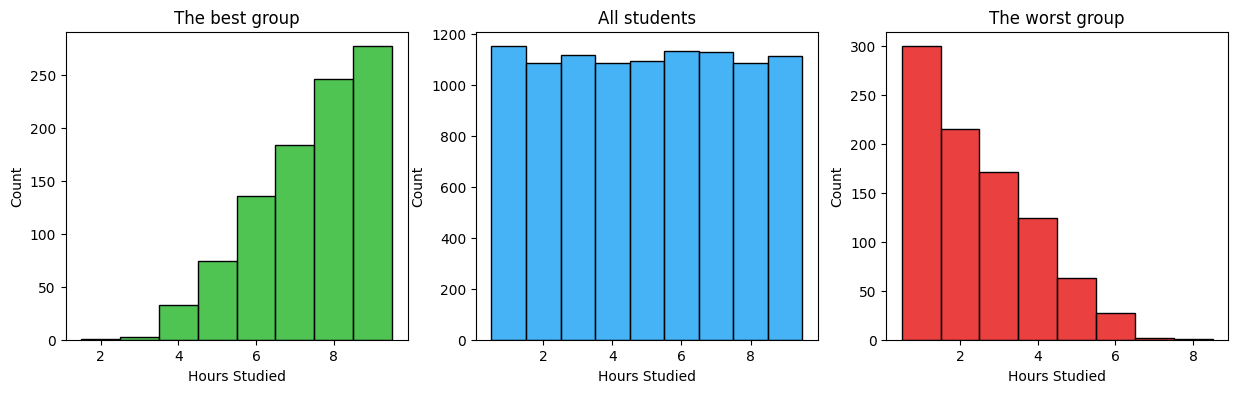

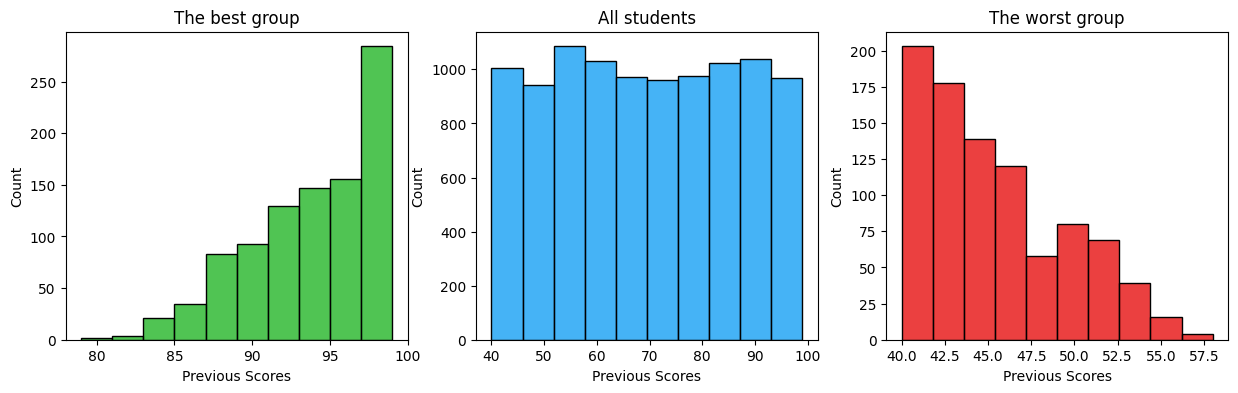

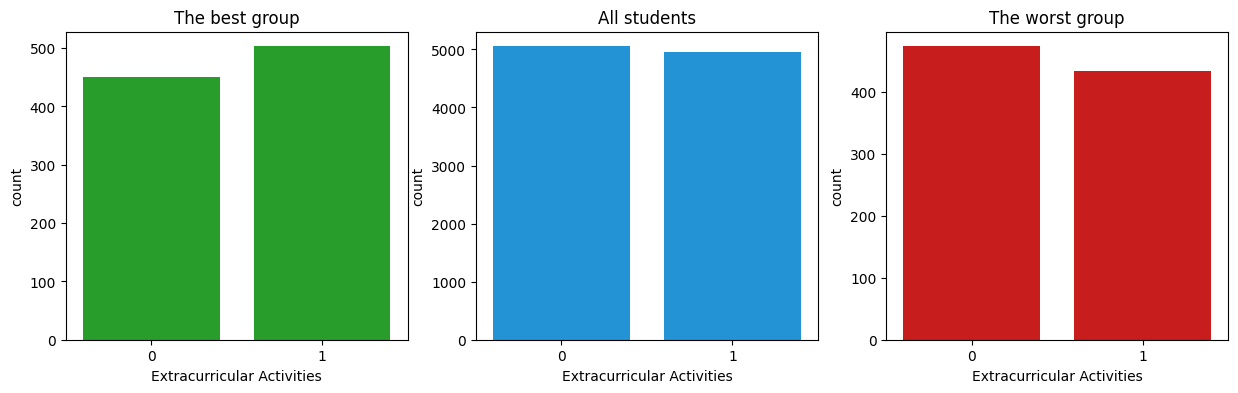

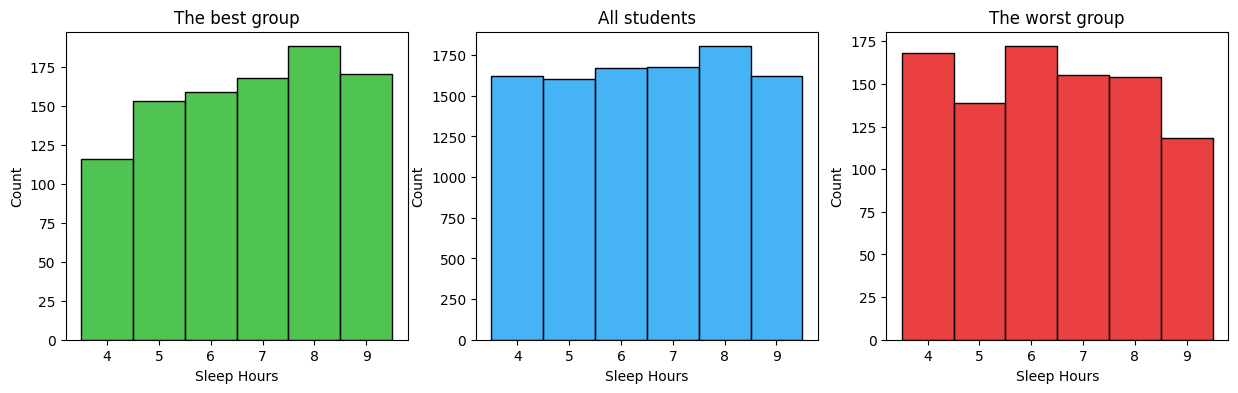

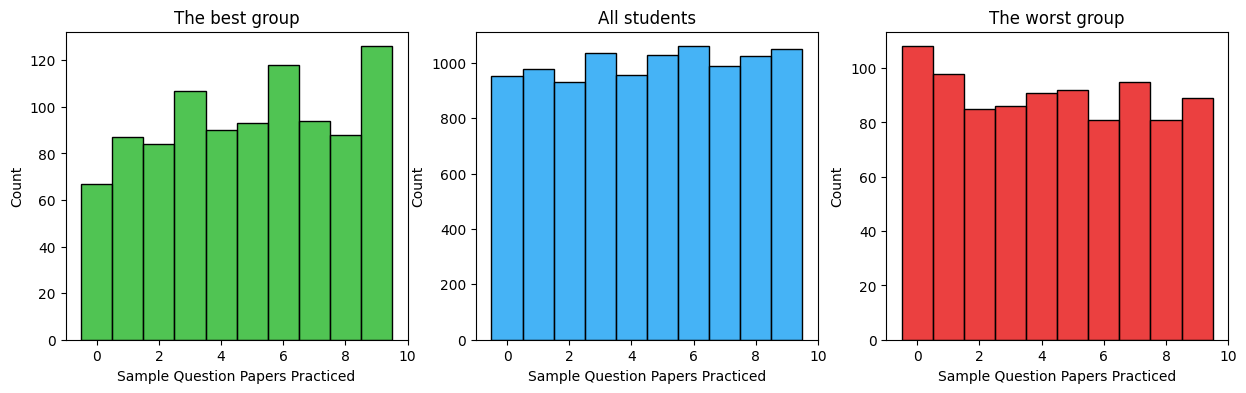

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.histplot(df_A, x='Hours Studied', discrete=True, color='#15B01A', ax=axes[0])
sns.histplot(df, x='Hours Studied', discrete=True, color='#069AF3', ax=axes[1])
sns.histplot(df_B, x='Hours Studied', discrete=True, color='#E50000',ax=axes[2])
axes[0].set_title('The best group')
axes[1].set_title('All students')
axes[2].set_title('The worst group')

fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.histplot(df_A, x='Previous Scores', bins=10, color='#15B01A', ax=axes[0])
sns.histplot(df, x='Previous Scores', bins=10, color='#069AF3', ax=axes[1])
sns.histplot(df_B, x='Previous Scores', bins=10, color='#E50000',ax=axes[2])
axes[0].set_title('The best group')
axes[1].set_title('All students')
axes[2].set_title('The worst group')

fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.countplot(df_A, x='Extracurricular Activities', color='#15B01A', ax=axes[0])
sns.countplot(df, x='Extracurricular Activities', color='#069AF3', ax=axes[1])
sns.countplot(df_B, x='Extracurricular Activities', color='#E50000',ax=axes[2])
axes[0].set_title('The best group')
axes[1].set_title('All students')
axes[2].set_title('The worst group')
axes[0].set_xticks([0, 1])
axes[1].set_xticks([0, 1])
axes[2].set_xticks([0, 1])

fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.histplot(df_A, x='Sleep Hours', discrete=True, color='#15B01A', ax=axes[0])
sns.histplot(df, x='Sleep Hours', discrete=True, color='#069AF3', ax=axes[1])
sns.histplot(df_B, x='Sleep Hours', discrete=True, color='#E50000',ax=axes[2])
axes[0].set_title('The best group')
axes[1].set_title('All students')
axes[2].set_title('The worst group')

fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.histplot(df_A, x='Sample Question Papers Practiced', discrete=True, color='#15B01A', ax=axes[0])
sns.histplot(df, x='Sample Question Papers Practiced', discrete=True, color='#069AF3', ax=axes[1])
sns.histplot(df_B, x='Sample Question Papers Practiced', discrete=True, color='#E50000',ax=axes[2])
axes[0].set_title('The best group')
axes[1].set_title('All students')
axes[2].set_title('The worst group')


The scatterplots below will show the relationships between the different predictiors and the target.

<Axes: xlabel='Sample Question Papers Practiced', ylabel='Performance Index'>

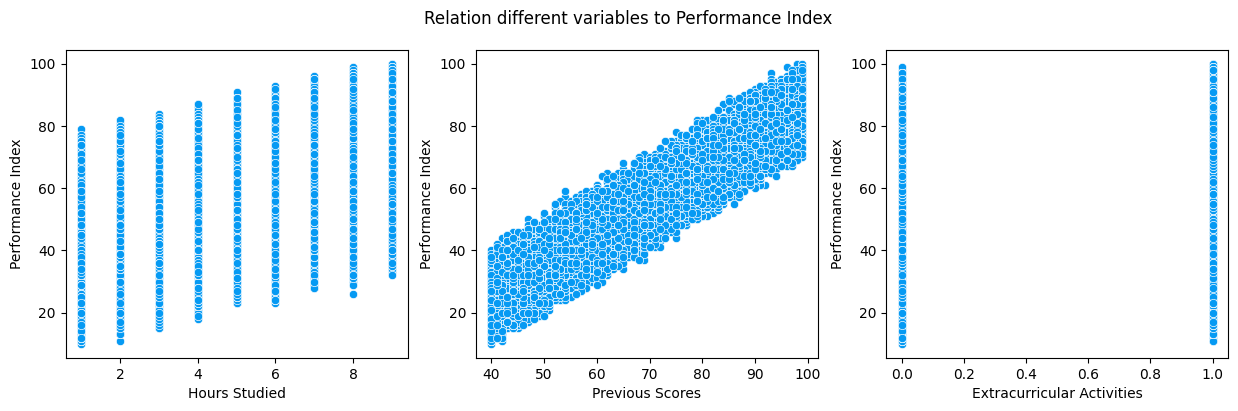

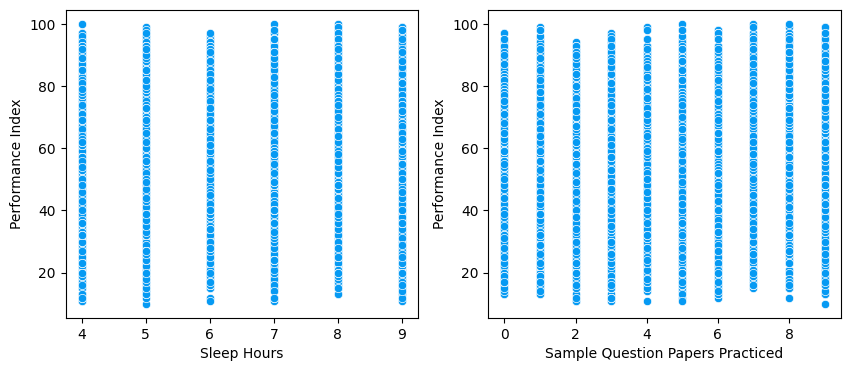

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle('Relation different variables to Performance Index')
sns.scatterplot(df, x='Hours Studied', y='Performance Index', color='#069AF3', ax=axes[0])
sns.scatterplot(df, x='Previous Scores', y='Performance Index', color='#069AF3', ax=axes[1])
sns.scatterplot(df, x='Extracurricular Activities', y='Performance Index', color='#069AF3', ax=axes[2])
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.scatterplot(df, x='Sleep Hours', y='Performance Index', color='#069AF3', ax=axes[0])
sns.scatterplot(df, x='Sample Question Papers Practiced', y='Performance Index', color='#069AF3', ax=axes[1])

We can see a correlation between Performance Index and Hours Studied, and between Performance Index and Previous Scores. Here are some takeaways:
- There isn't any student who learnt at least 7 hours and got Performance Index below 20.
- There isn't any student who learnt only 1 hour and got Performance Index more than 80.
- Previous Scores is the most predictive variable, because knowing that a student has a specific Previous Scores, the Performance Index will differ from this value no more than about 30 (more about it below)
- If student A has Previous Scores equal to 35 and student B has Previous Scores equal to 100, based on the dataset, there is no chance, that they will get the same Performance Index.
- The remaining variables are fairly evenly distributed. This means it will be hard to predict Performance Index based on these predictors. 


Below, you can find a calculation of the difference between the highest and the lowest Performance Index for students with specific Previous Scores.


In [13]:
differences = []
for i in range(40,101):
    temp = df[df['Previous Scores']==i][['Performance Index']]
    differences.append((temp.max() - temp.min())[0])

Text(0.5, 1.0, 'Range of Performance Index for fixed Previous Scores')

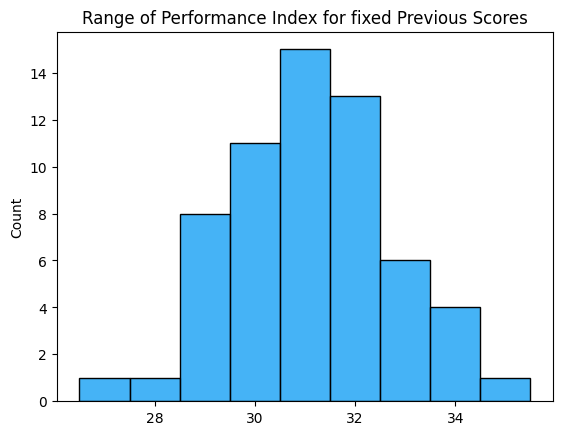

In [14]:
sns.histplot(differences, discrete=True, color='#069AF3')
plt.title('Range of Performance Index for fixed Previous Scores')



The difference between the highest and the smallest Performance Index for students with fixed Previous Scores lays between 27 and 35. The most popular ranges are around 31.

The heatmap will show if the variables are correlated with themselves.

<Axes: >

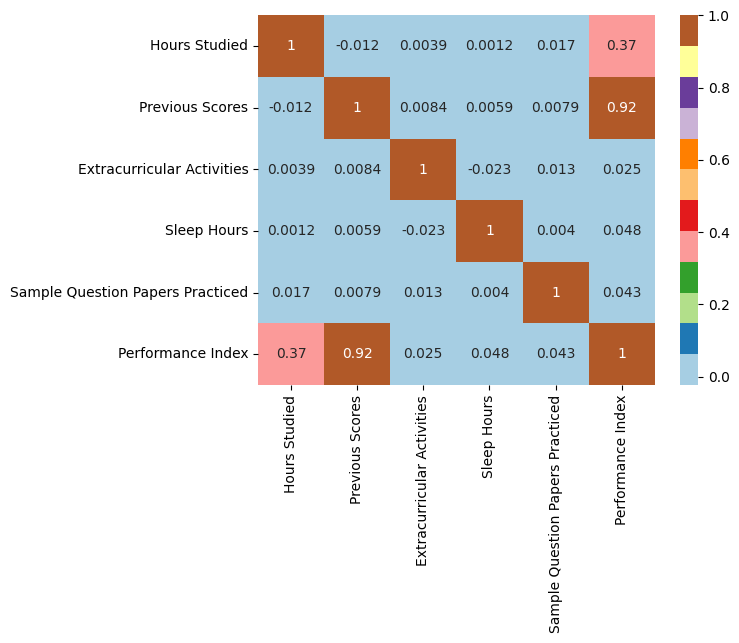

In [15]:
sns.heatmap(df.corr(), cmap="Paired", annot=True)

The heatmap confirms the previous thoughts about the correlations. The Performance Index is highly correlated with Previous Scores and weakly correlated with Hours Studied. The rest of variables has no correlation to Performance Index.

<a class="anchor"  id="chapter4"></a>
# IV. Building the Models  

<p>In this part we will build 7 models to predict Performance Index. In each of the model we will make cross validation to see how well can the model learn from data. Finally, we will report the metrics of the best models using test data.

From the whole dataset, 90% of the data will be used to train the model. The remaining 10% will serve as test data.

In each model we will save the mean value of cross-validation scores as result1, result2, ect.</p>

In [16]:
X = df[['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']]
y = df[['Performance Index']]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

<a class="anchor"  id="sec4_1"></a>
## 1. Simple Linear Regression 

In the first model, we will make Simple Linear Regression using only Previous Scores variable to predict Performance Index.

In [18]:
model1 = LinearRegression()
scores1 = cross_val_score(model1, X_train[['Previous Scores']], y_train, cv=5)
scores1


array([0.83652017, 0.83383489, 0.83607838, 0.84103841, 0.8425198 ])

In [19]:
result1 = scores1.mean()
model1.fit(X_train[['Previous Scores']], y_train)

LinearRegression()

<a class="anchor"  id="sec4_2"></a>
## 2. Multiple Linear Regression - 2 variables 

In [20]:
model2 = LinearRegression()
scores2 = cross_val_score(model2, X_train[['Previous Scores', 'Hours Studied']], y_train, cv=5)
scores2

array([0.98588622, 0.9857396 , 0.98638445, 0.98633632, 0.98527834])

In [21]:
result2 = scores2.mean()
model2.fit(X_train[['Previous Scores', 'Hours Studied']], y_train)

LinearRegression()

<a class="anchor"  id="sec4_3"></a>
## 3. Multiple Linear Regression - 3 variables

To choose the third variable of the model, we will perform Forward Selection. 

In [22]:
model3 = LinearRegression()
sfs = SequentialFeatureSelector(model3, n_features_to_select=3)
sfs.fit(X_train, y_train)
sfs.get_support()

array([ True,  True, False,  True, False])

Forward Selection indicates that we should add Sleep Hours as a third variable to the model.

In [23]:
scores3 = cross_val_score(model3, X_train[['Previous Scores', 'Hours Studied', 'Sleep Hours']], y_train, cv=5)
scores3

array([0.98769983, 0.9876873 , 0.98795487, 0.98786871, 0.98720918])

In [24]:
result3 = scores3.mean()
model3.fit(X_train[['Previous Scores', 'Hours Studied', 'Sleep Hours']], y_train)

LinearRegression()

The scores of model 2. and 3. are very similar. That's why in the next models we will use only two independent variables.

<a class="anchor"  id="sec4_4"></a>
## 4. Lasso Regression 

At the beginning we'll use Grid Search to find the best value of alpha (regularization term). Then, we will apply this parameter to the model.

In [25]:
parameters4 = {'alpha':(0.0001, 0.001, 0.01, 1)}
grid4 = GridSearchCV(Lasso(random_state=0), parameters4)
grid4.fit(X_train[['Previous Scores', 'Hours Studied']], y_train)
grid4.best_params_


{'alpha': 0.0001}

In [26]:
model4 = Lasso(alpha=0.0001)
scores4 = cross_val_score(model4, X_train[['Previous Scores', 'Hours Studied']], y_train, cv=5)
result4 = scores4.mean()
scores4

array([0.98588622, 0.98573959, 0.98638445, 0.98633633, 0.98527835])

<a class="anchor"  id="sec4_5"></a>
## 5. Ridge Regression 

Similarly as in Lasso, we will start with Grid Search. This time, apart from finding the best regularization term, we also want to chose a computational method, so-called solver.

In [27]:
parameters5 = {'alpha':(0.0001, 0.001, 0.01, 1),
            'solver': ('auto', 'svd', 'cholesky', 'sparse_cg', 'sag')}
grid5 = GridSearchCV(Ridge(random_state=0), parameters5, n_jobs=1)
grid5.fit(X_train[['Previous Scores', 'Hours Studied']], y_train)
grid5.best_params_

{'alpha': 0.0001, 'solver': 'sag'}

Here 'sag' stands for Stochastic Average Gradient descent. 

In [28]:
model5 = Ridge(alpha=0.0001, solver='sag')
scores5 = cross_val_score(model5, X_train[['Previous Scores', 'Hours Studied']], y_train, cv=5)
result5 = scores5.mean()
scores5

array([0.98588627, 0.98572137, 0.986388  , 0.98633464, 0.98528826])

There aren't big differences between Lasso and Ridge Regression. That's why I will not perform Elastic Net.

<a class="anchor"  id="sec4_6"></a>
## 6. Regression Tree 


This time Grid Search will help us decide which function to choose to measure the quality of a split. What's more, we have to choose a split strategy, denoted here as splitter.

In [29]:
parameters = {'criterion':
    ('squared_error', 'friedman_mse', 'absolute_error','poisson'), 
    'splitter': ('best', 'random')
    }
grid6 = GridSearchCV(DecisionTreeRegressor(random_state=0), parameters)
grid6.fit(X_train[['Previous Scores', 'Hours Studied']], y_train)
grid6.best_params_

{'criterion': 'squared_error', 'splitter': 'random'}

In [30]:
model6 = DecisionTreeRegressor(criterion='squared_error', splitter='random')
scores6 = cross_val_score(model6, X_train[['Previous Scores', 'Hours Studied']], y_train, cv=5)
result6 = scores6.mean()
scores6

array([0.98476119, 0.98442734, 0.98516834, 0.98509794, 0.98435714])

<a class="anchor"  id="sec4_7"></a>
## 7. Polynomial Regression 

The second degree polynomial will be used. To perform it, we have to transform the data.

In [31]:
poly = PolynomialFeatures(degree=2)
poly_features = poly.fit_transform(X[['Previous Scores', 'Hours Studied']])
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(poly_features, y, test_size=0.1, random_state=0)
model7 = LinearRegression()
scores7 = cross_val_score(model7, X_train_p, y_train_p, cv=5,)
result7 = scores7.mean()
scores7

array([0.98589192, 0.98576293, 0.98638526, 0.9863431 , 0.98526732])

<a class="anchor"  id="sec4_8"></a>
## Models summary 

To compare the models we will present the mean value of cross-validation scores.

In [32]:
d = {'Model':
    ['Simple Linear Regression',
    'Multiple Linear Regression - 2 var',
    'Multiple Linear Regression - 3 var',
    'Lasso Regression',
    'Ridge Regression',
    'Regression Tree',
    'Polynomial Regression'], 
    'R-squared':
    [result1,
    result2,
    result3,
    result4,
    result5,
    result6,
    result7]}

results = pd.DataFrame(d, index=[1,2,3,4,5,6,7])
results.sort_values(by='R-squared', ascending=False)

,Model,R-squared
3,Multiple Linear Regression - 3 var,0.987684
7,Polynomial Regression,0.985930
2,Multiple Linear Regression - 2 var,0.985925
4,Lasso Regression,0.985925
5,Ridge Regression,0.985924
6,Regression Tree,0.984762
1,Simple Linear Regression,0.837998


As we discussed previously, the models gain very similar performance to each other. No mather if we chose very simple models like Multiple Linear Regression or more complicated like Regression Trees or Regularized Regression. To chose the appropriate model, we will compare the following metrics:
- Mean Square Error
- Max Error

for models:<br>
2. Multiple Linear Regression - 2 variables<br>
3. Multiple Linear Regression - 3 variables<br>
7. Polynomial Regression<br>

In [33]:
MSE2 = cross_val_score(model2, X_train[['Previous Scores', 'Hours Studied']], y_train, cv=5, scoring='neg_mean_squared_error')
MSE3 = cross_val_score(model3, X_train[['Previous Scores', 'Hours Studied', 'Sleep Hours']], y_train, cv=5, scoring='neg_mean_squared_error')
MSE7 = cross_val_score(model7, X_train_p, y_train_p, cv=5, scoring='neg_mean_squared_error')
MSE2, MSE3, MSE7

(array([-5.16311518, -5.26359257, -4.97159331, -5.14849793, -5.56166796]),
 array([-4.4996569 , -4.54468735, -4.39816748, -4.57108989, -4.83221946]),
 array([-5.16102978, -5.25498382, -4.97129799, -5.14594509, -5.56583173]))

In [34]:
ME2 = cross_val_score(model2, X_train[['Previous Scores', 'Hours Studied']], y_train, cv=5, scoring='max_error')
ME3 = cross_val_score(model3, X_train[['Previous Scores', 'Hours Studied', 'Sleep Hours']], y_train, cv=5, scoring='max_error')
ME7 = cross_val_score(model7, X_train_p, y_train_p, cv=5, scoring='max_error')
ME2, ME3, ME7

(array([-8.92996304, -7.92343299, -6.78912829, -9.42165338, -9.15273861]),
 array([-7.75893318, -7.02448991, -7.05265041, -8.58823618, -7.99664412]),
 array([-8.88409895, -7.88774548, -6.72296691, -9.42355314, -9.21036233]))

When comparing models 2. and 7. we can see that MSE and ME are very similar. Moreover, the more complicated model 7. often performs slightly worse then the basic model 2. Therefore, we reject the model 7. (Polynomial Regression).

When comparing models 2. and 3., it is clear that adding third explanatory variable will improve performance. The key question remains whether the improvement in metrics is large enough to complicate the model by adding the third variable.

In my opinion, this is an open question, so in the end I suggest choosing both models.

<a class="anchor"  id="chapter5"></a>
# V. Final Report 

In [35]:
model2.fit(X_train[['Previous Scores', 'Hours Studied']], y_train)
predict2 = model2.predict(X_test[['Previous Scores', 'Hours Studied']])
finalRSq2 = r2_score(y_test, predict2)
finalMSE2 = mean_squared_error(y_test, predict2)
finalMAE2 = mean_absolute_error(y_test, predict2)
finalME2 = max_error(y_test, predict2)

model3.fit(X_train[['Previous Scores', 'Hours Studied', 'Sleep Hours']], y_train)
predict3 = model3.predict(X_test[['Previous Scores', 'Hours Studied', 'Sleep Hours']])
finalRSq3 = r2_score(y_test, predict3)
finalMSE3 = mean_squared_error(y_test, predict3)
finalMAE3 = mean_absolute_error(y_test, predict3)
finalME3 = max_error(y_test, predict3)

In [36]:
finalRSq2, finalMSE2, finalMAE2, finalME2

(0.9851902758772069, 5.188254975312726, 1.8313569499805968, 8.200998321549939)

In [37]:
finalRSq3, finalMSE3, finalMAE3, finalME3

(0.9871493623291838, 4.501932938030894, 1.70167524143667, 7.078258734113142)

<h4>Multiple Linear Regression with 2 variables:</h4>
<b>R-Squared:</b> 0.985190<br>
<b>Mean Squared Error:</b> 5.188255<br>
<b>Mean Absolute Error:</b> 1.831357<br>
<b>Max Error:</b> 8.200998<br>

<h4>Multiple Linear Regression with 3 variables:</h4>
<b>R-Squared:</b> 0.987149<br>
<b>Mean Squared Error:</b> 4.501933<br>
<b>Mean Absolute Error:</b> 1.701675<br>
<b>Max Error:</b> 7.078259<br>